In [1]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
from models import load_policy
import torch
from IPython import display
from typing import Optional, Tuple

In [3]:
def decision_square(mgrid: np.ndarray) -> Optional[Tuple[int, int]]:
    cost_so_far, came_from = maze.shortest_path(mgrid, (0, 0))
    path_to_cheese = maze.reconstruct_path(came_from, maze.get_cheese_pos(mgrid))

    tr = (mgrid.shape[0]-1, mgrid.shape[1]-1)
    cost_so_far, came_from = maze.shortest_path(mgrid, (0, 0), stop_condition=lambda _, c: c == tr)
    path_to_top_right = maze.reconstruct_path(came_from, tr)
    # if the paths diverge they can never connect again, since mazes have no cycles
    for i, (n1, n2) in enumerate(zip(path_to_cheese, path_to_top_right)):
        # print(f'step {i}/{min(len(path_to_cheese), len(path_to_top_right))}: {n1} {n2}')
        if n1 != n2:
            return path_to_cheese[i - 1]
    return None

building procgen...done


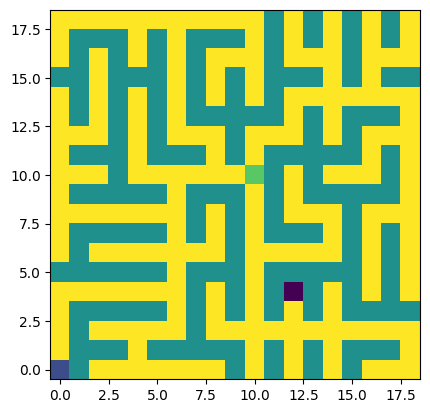

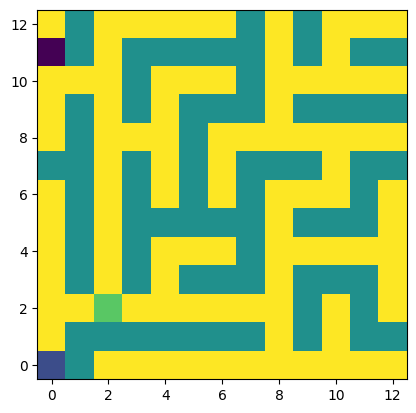

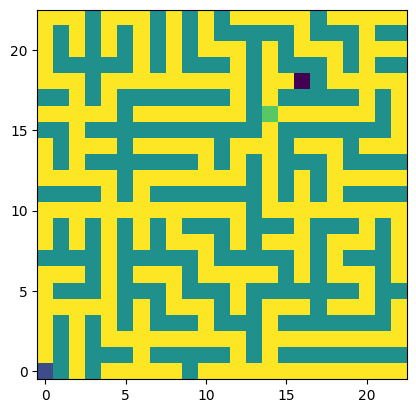

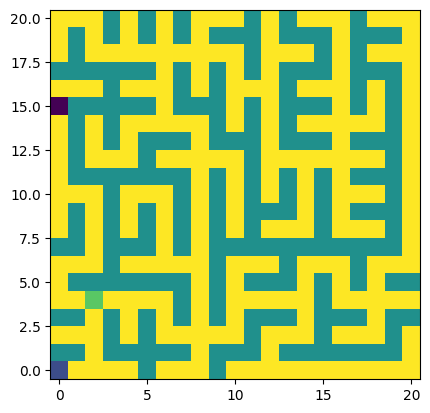

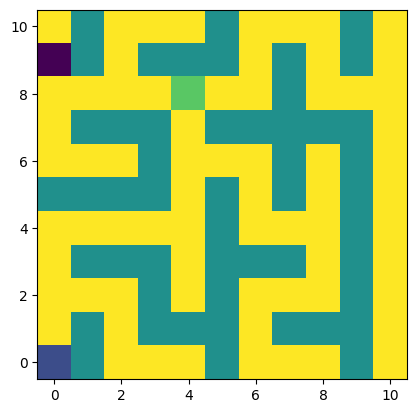

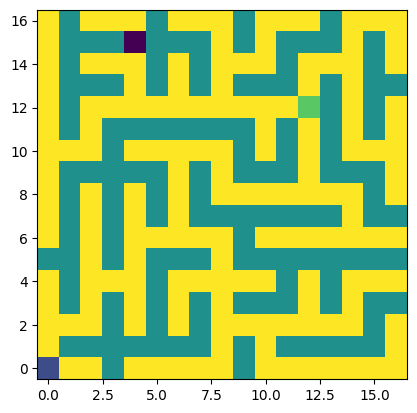

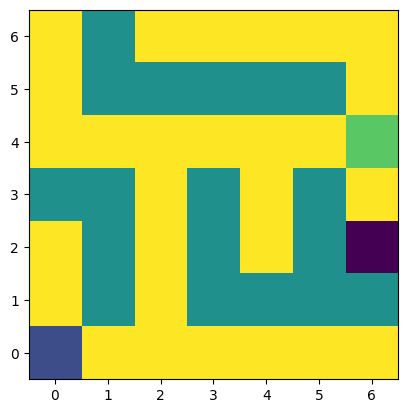

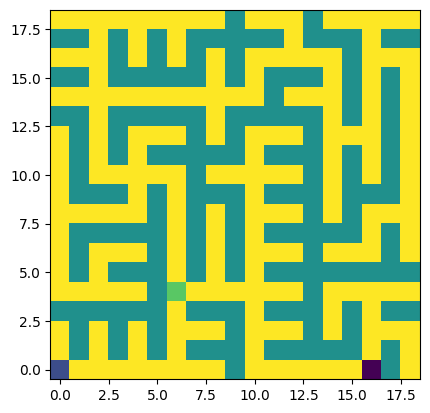

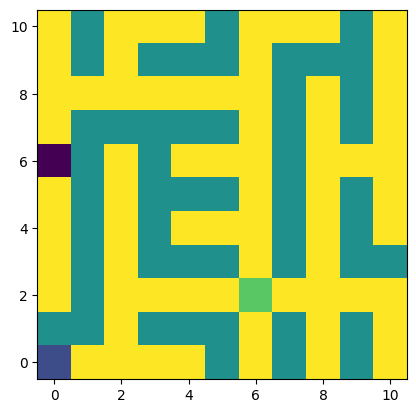

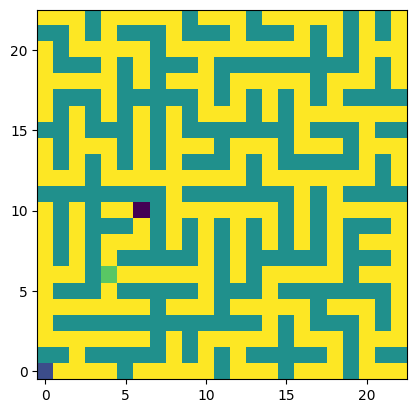

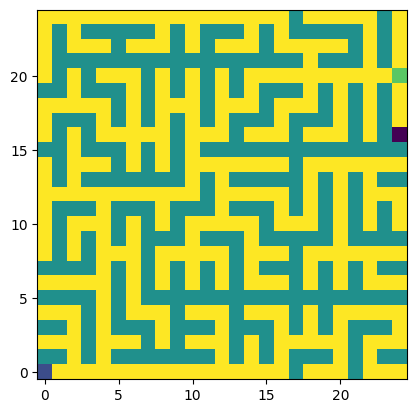

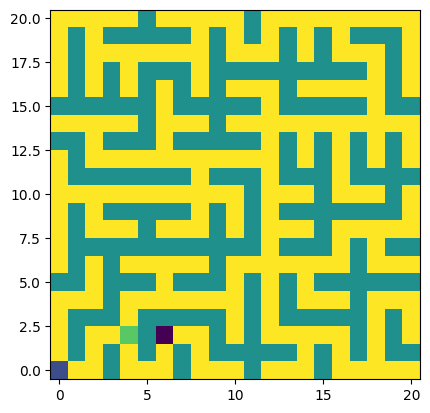

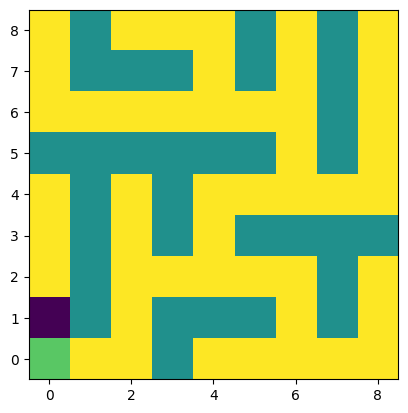

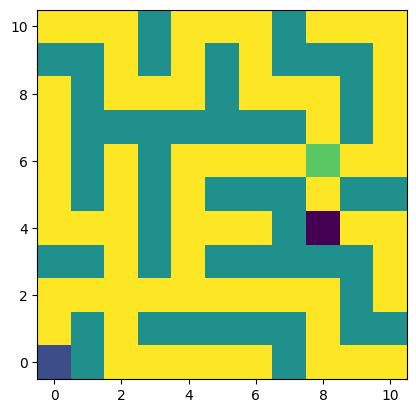

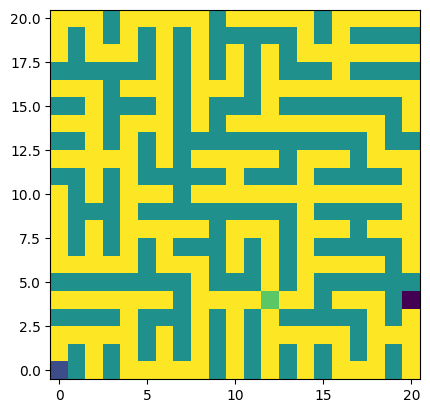

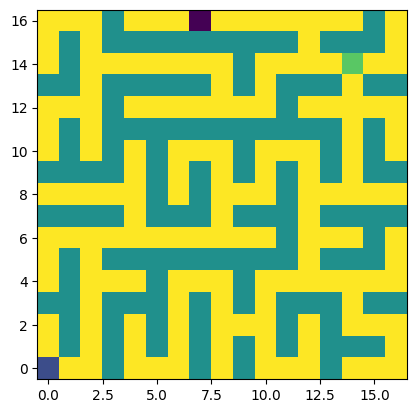

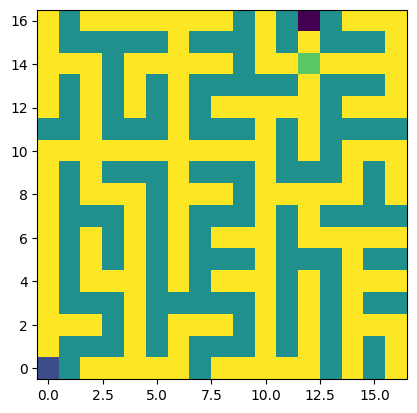

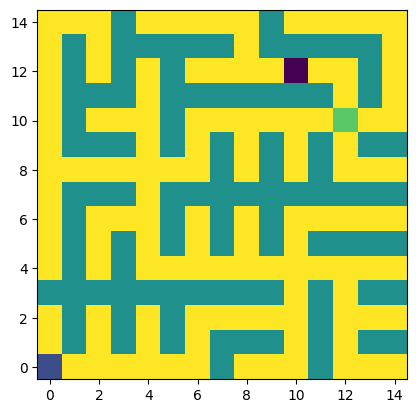

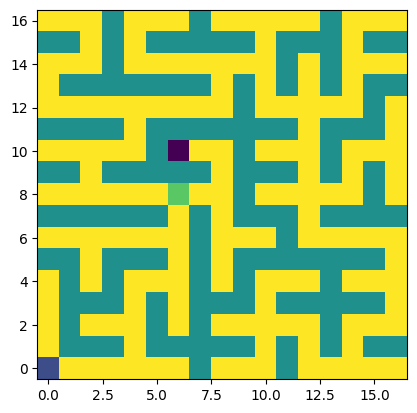

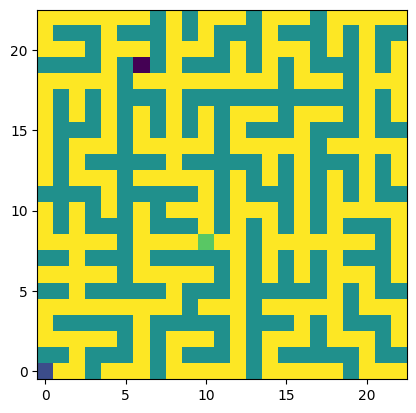

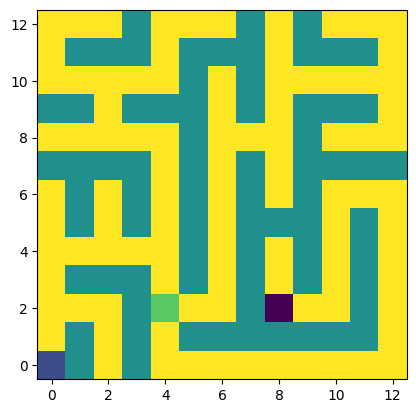

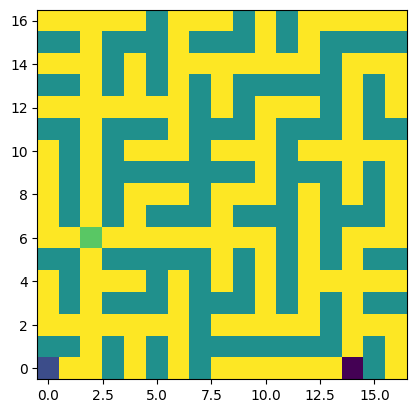

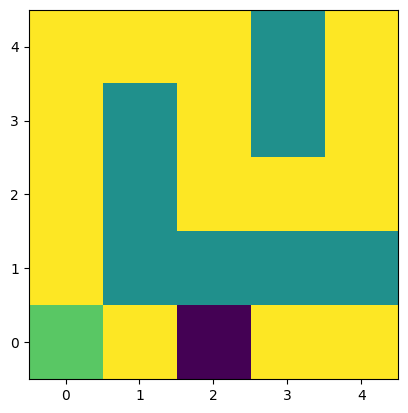

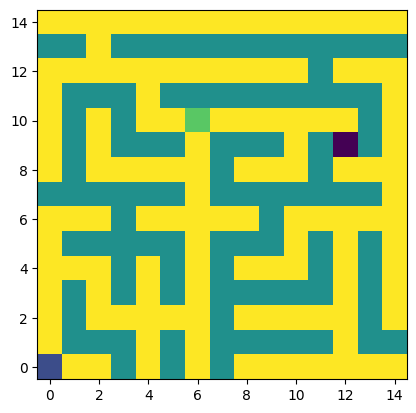

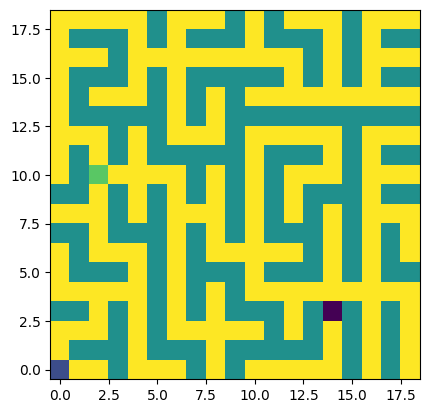

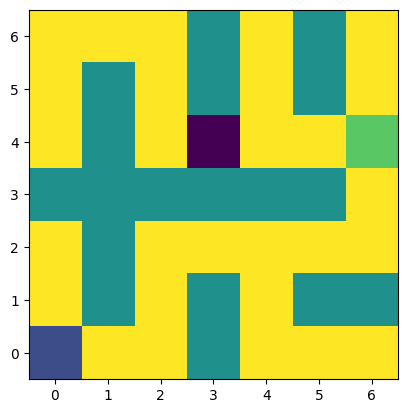

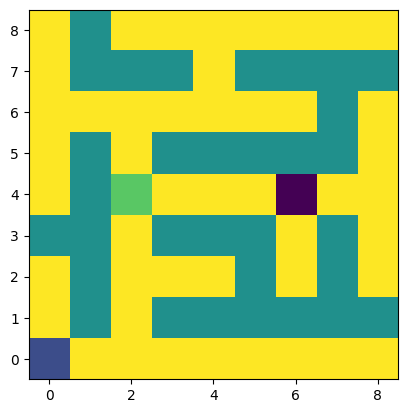

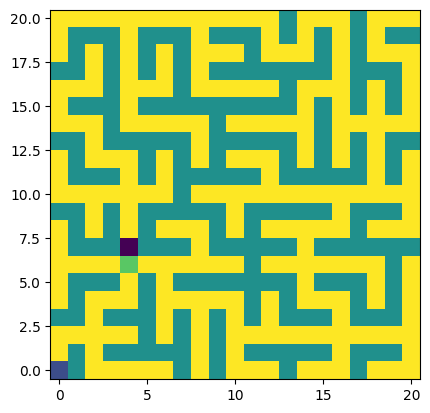

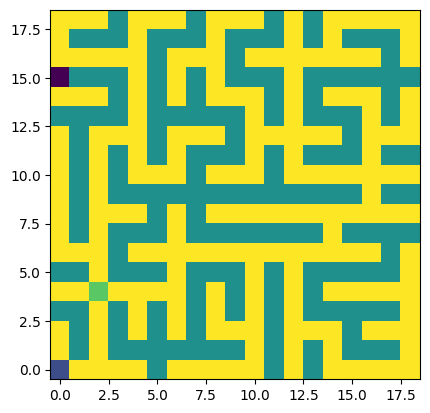

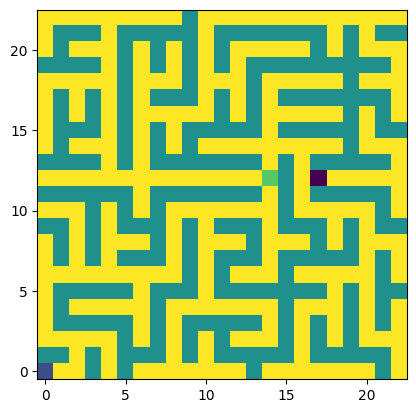

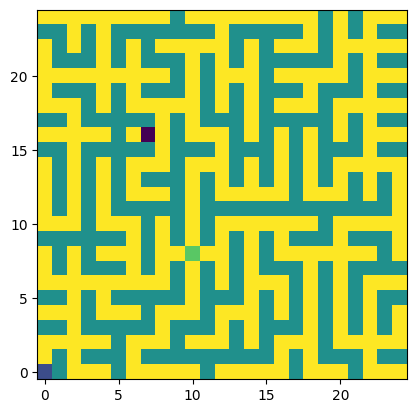

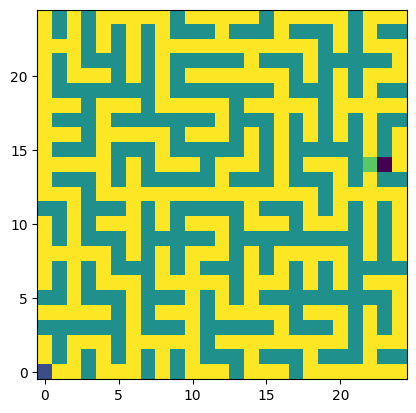

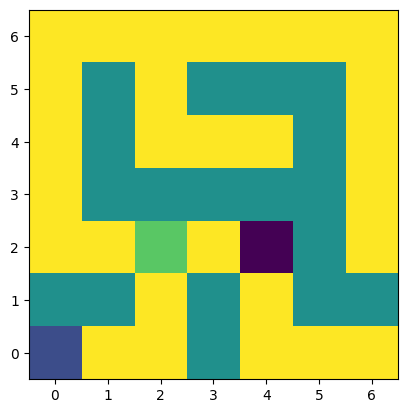

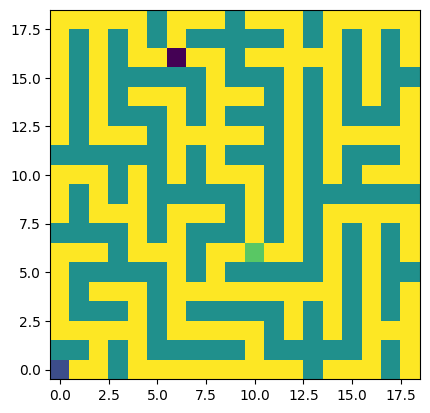

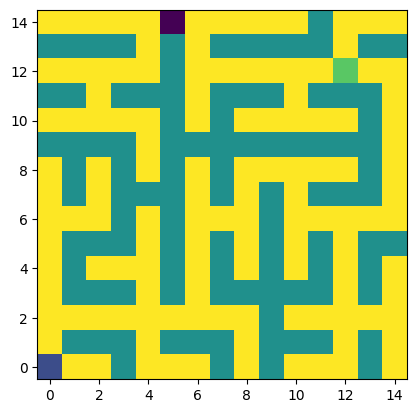

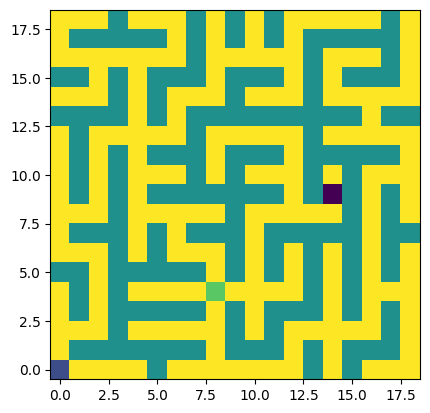

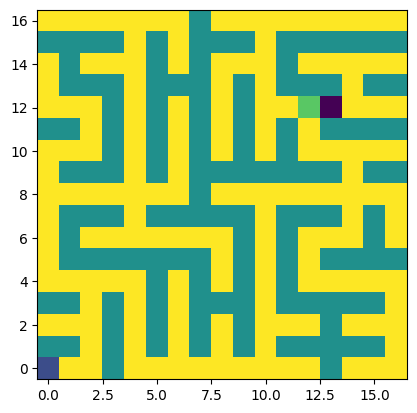

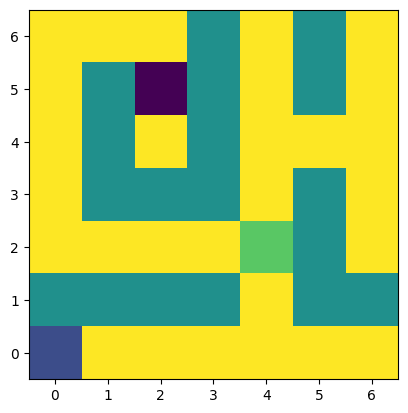

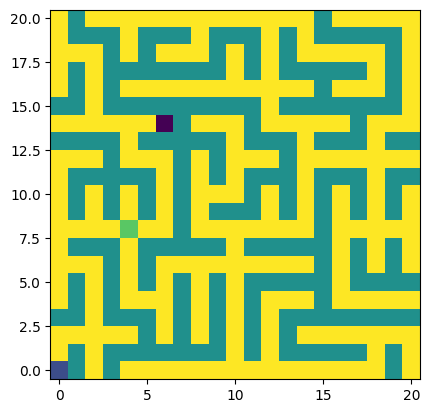

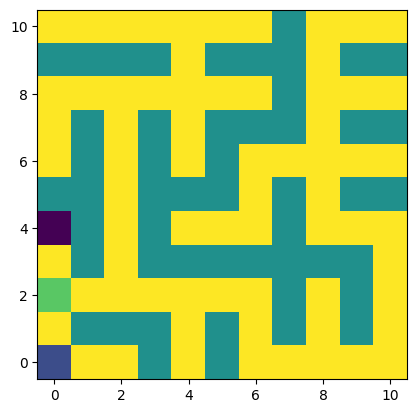

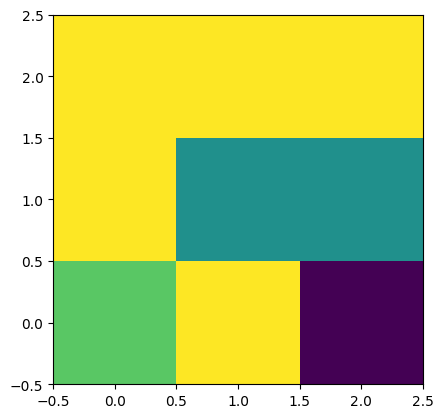

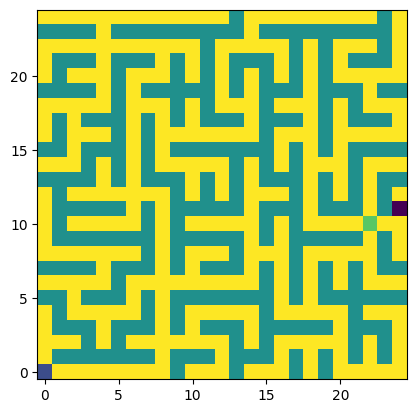

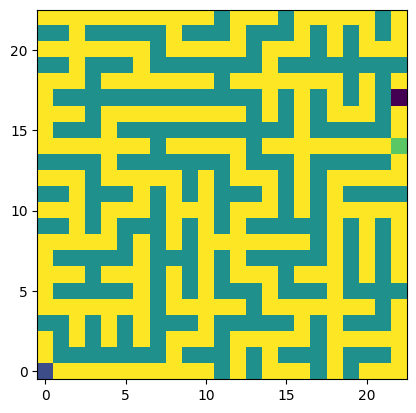

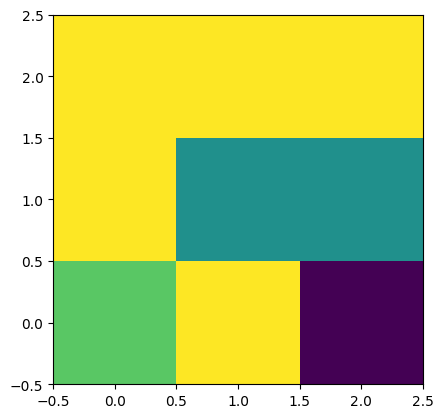

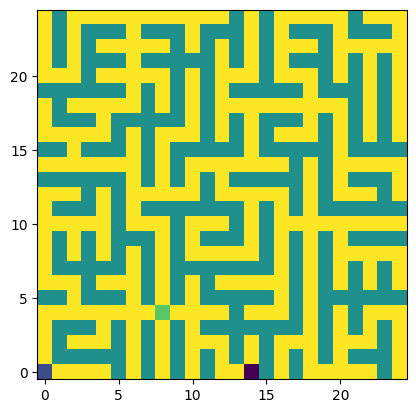

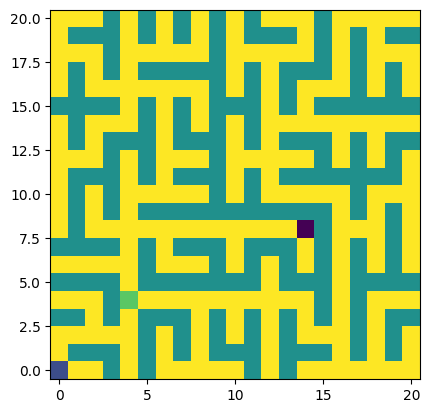

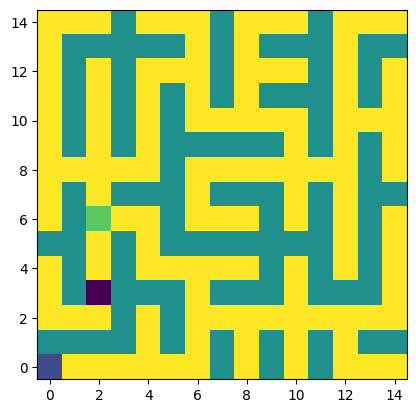

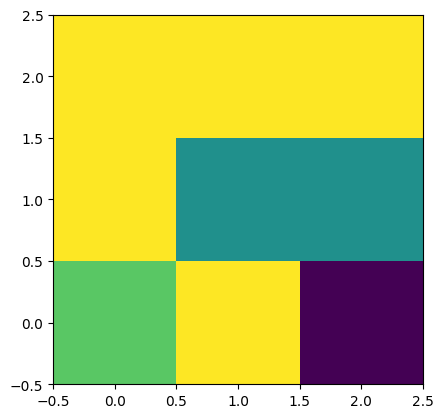

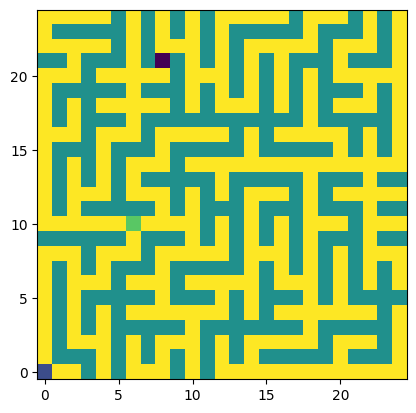

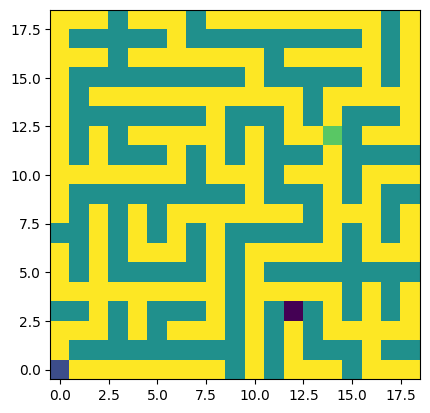

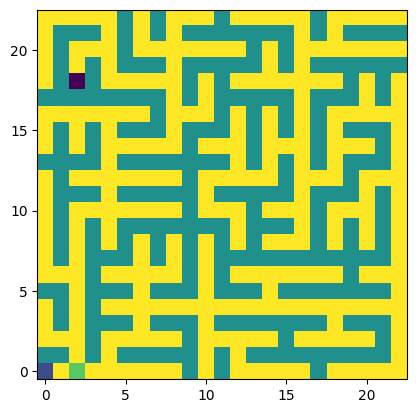

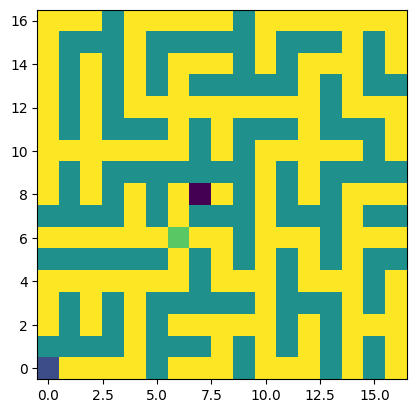

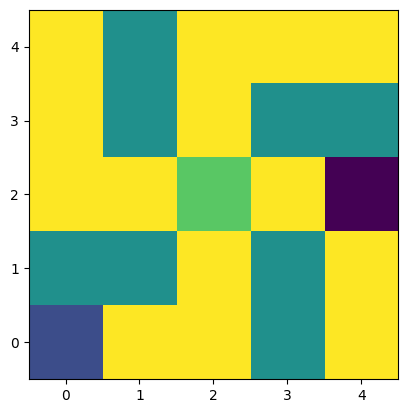

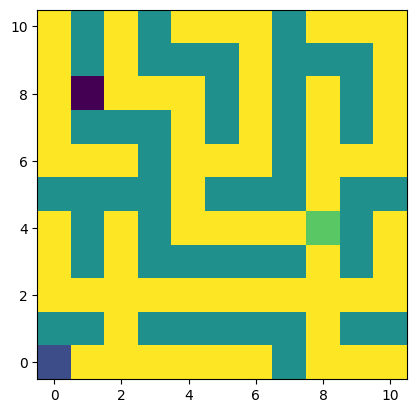

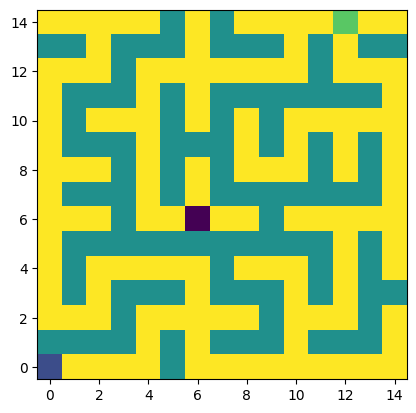

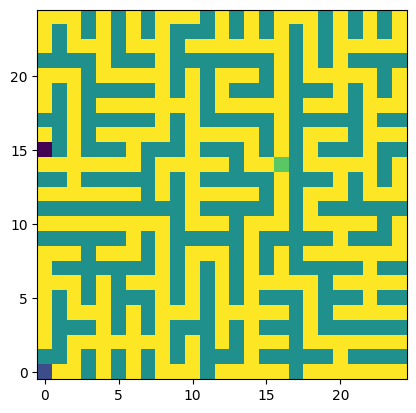

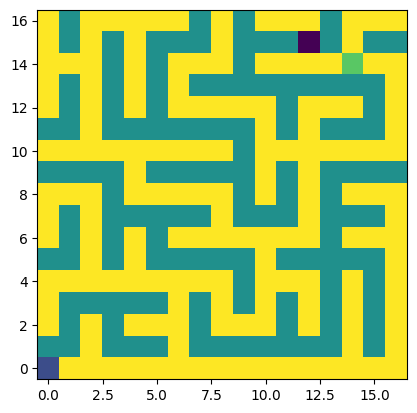

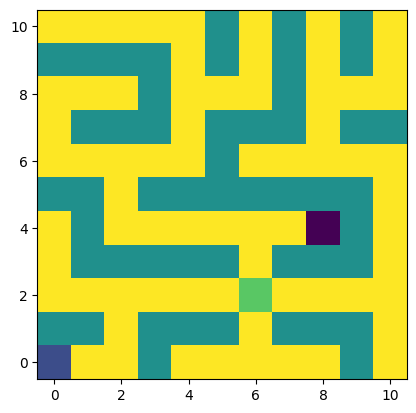

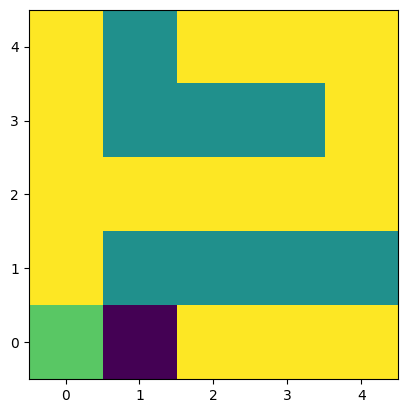

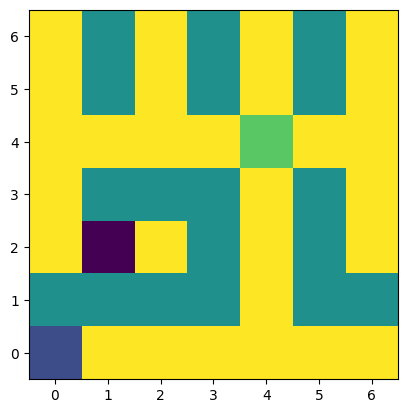

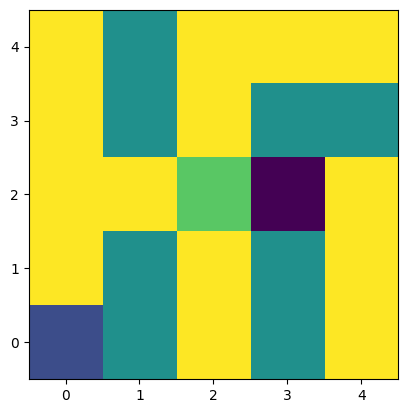

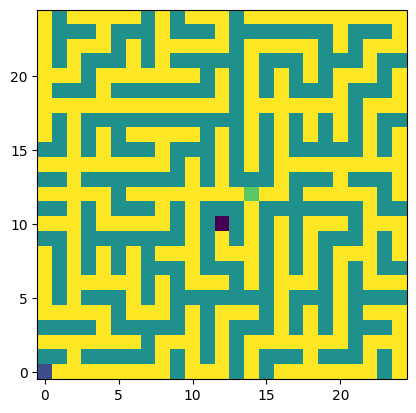

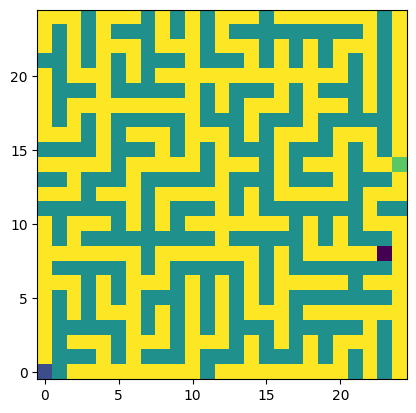

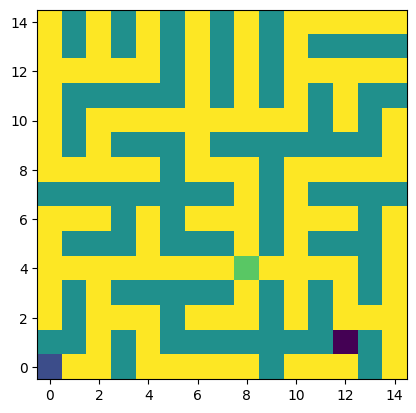

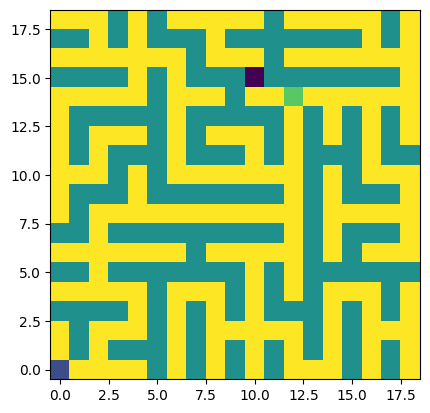

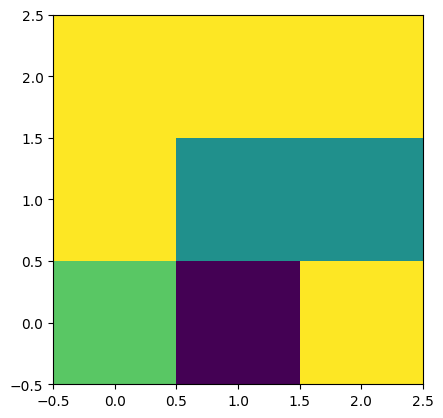

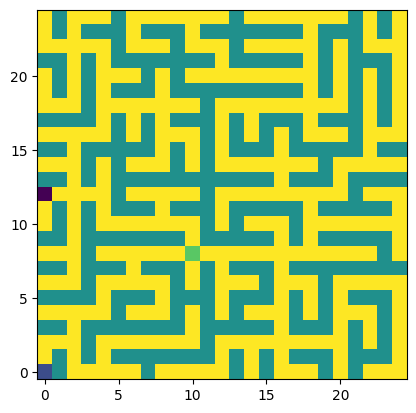

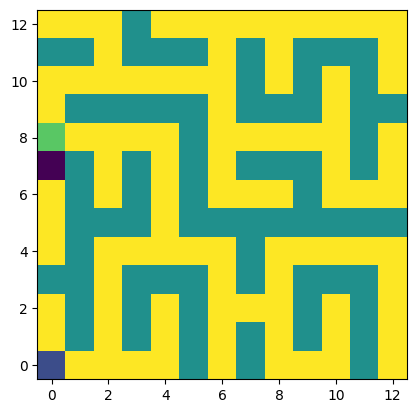

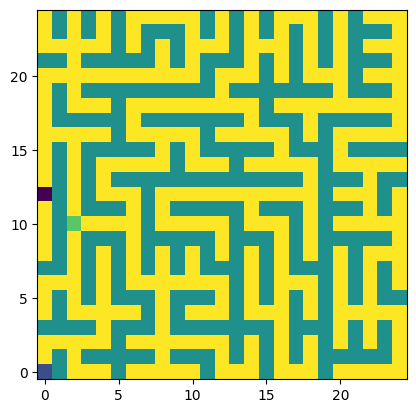

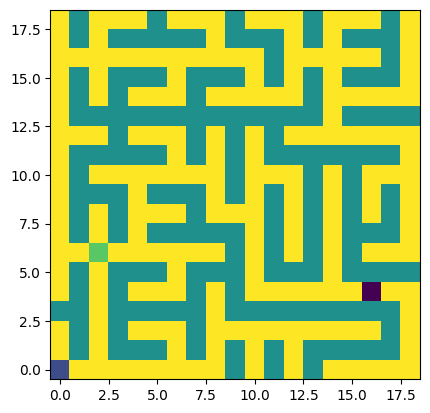

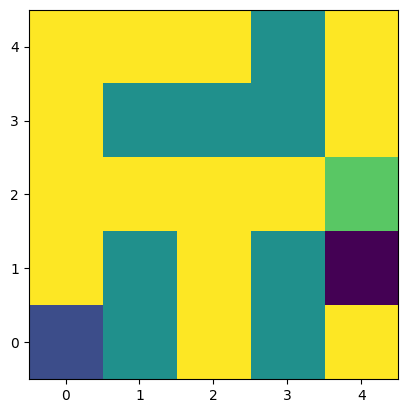

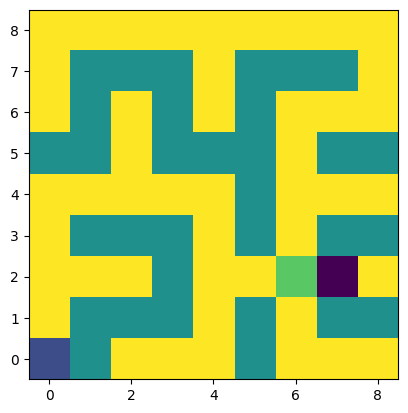

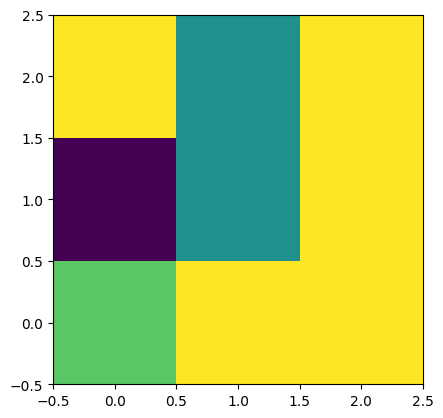

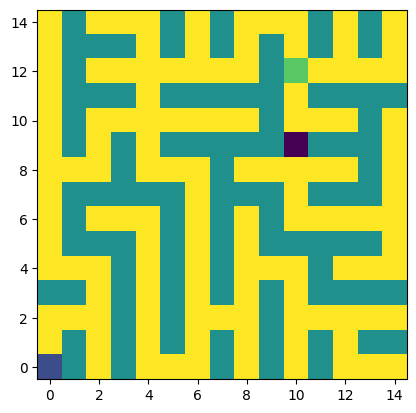

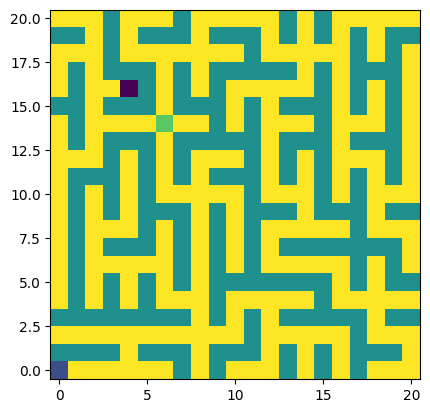

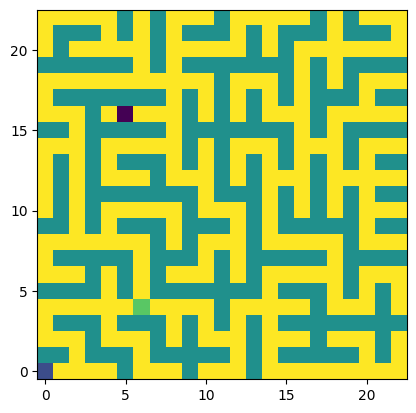

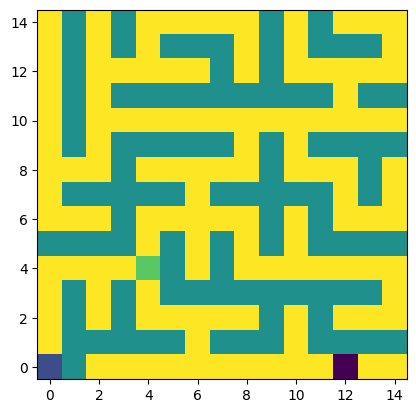

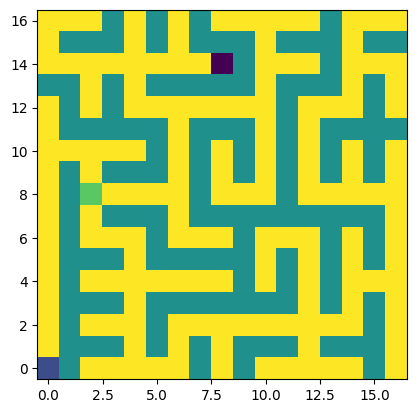

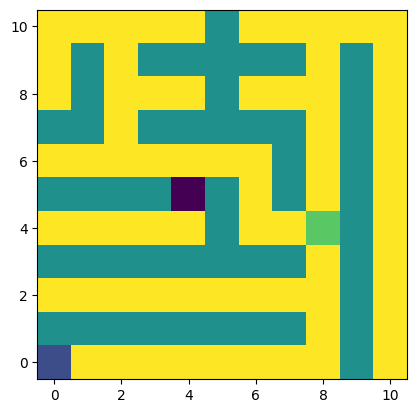

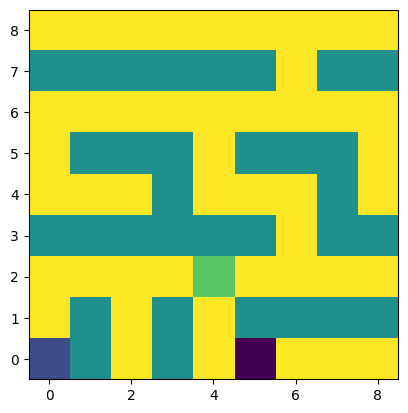

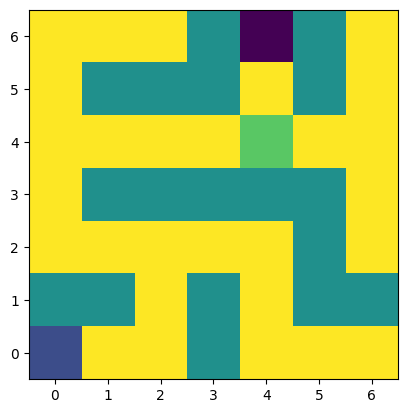

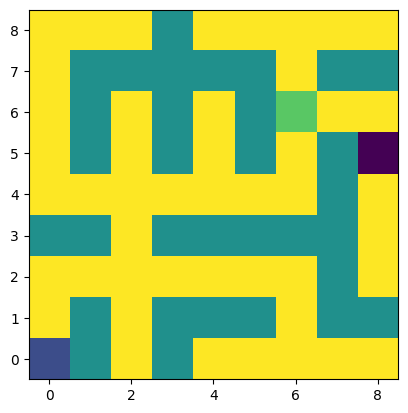

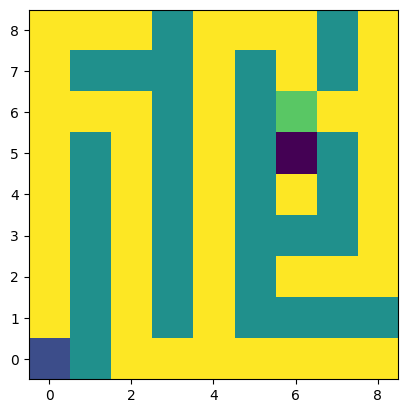

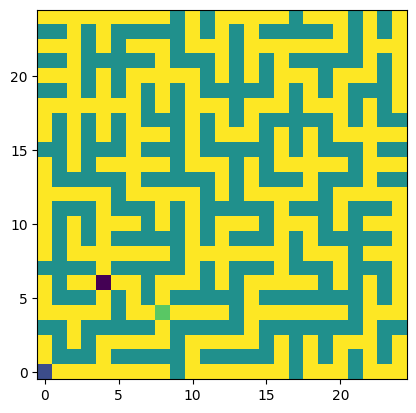

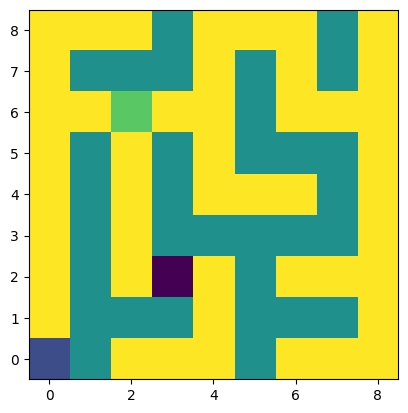

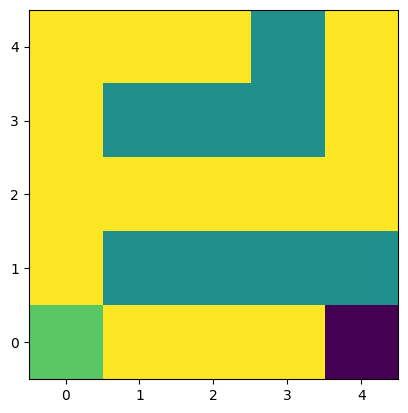

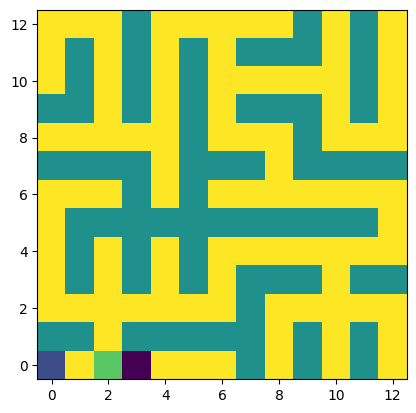

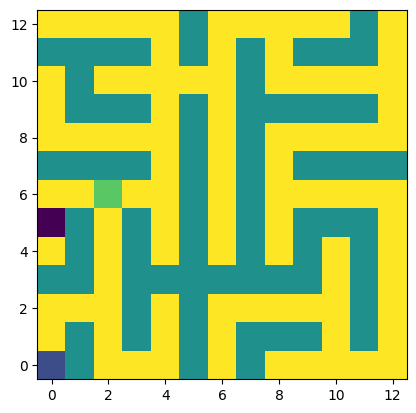

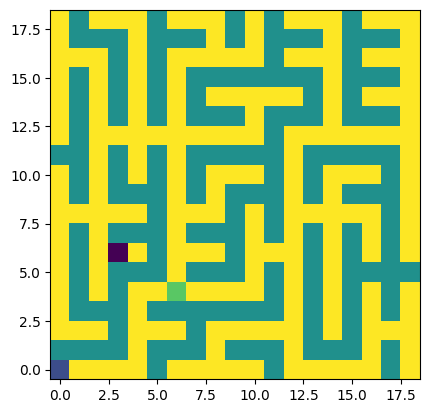

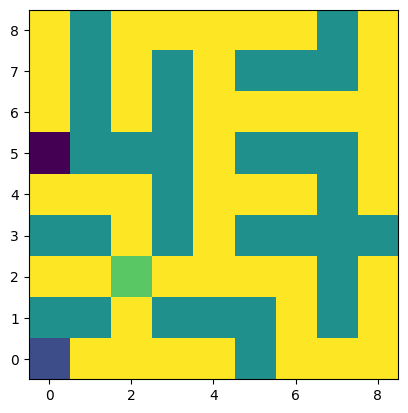

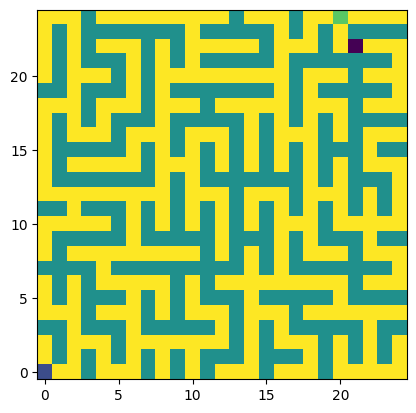

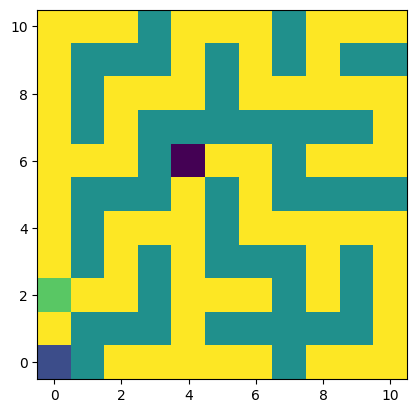

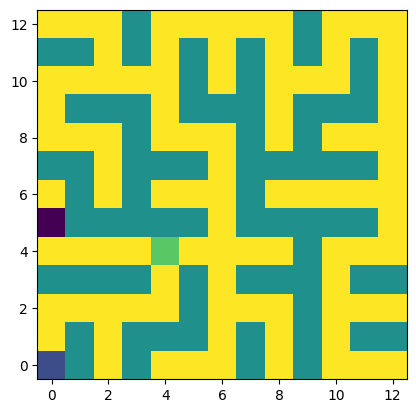

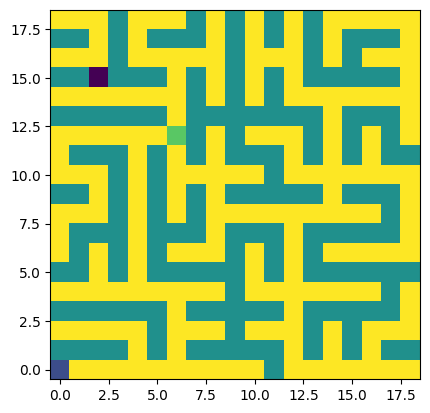

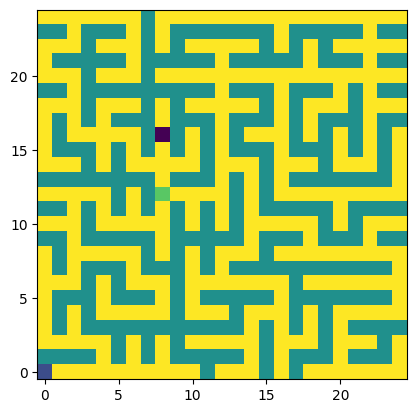

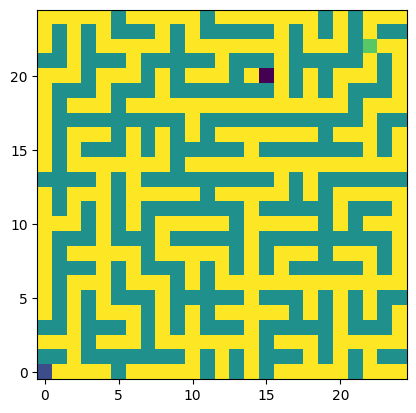

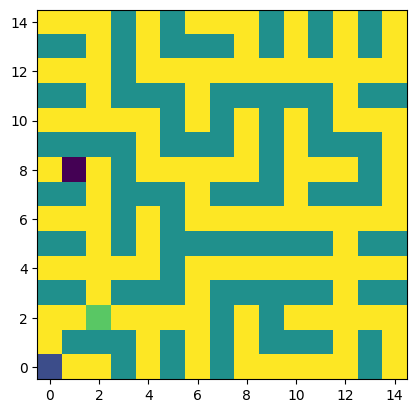

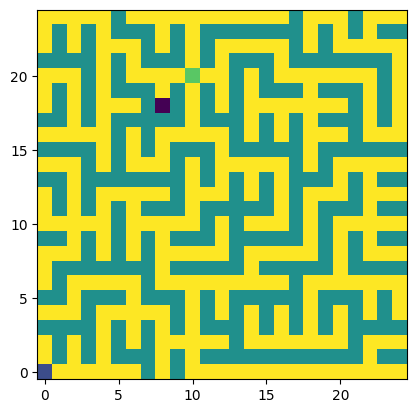

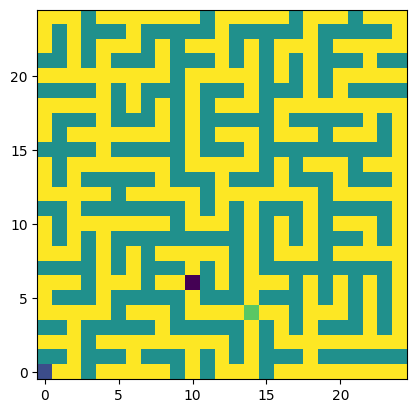

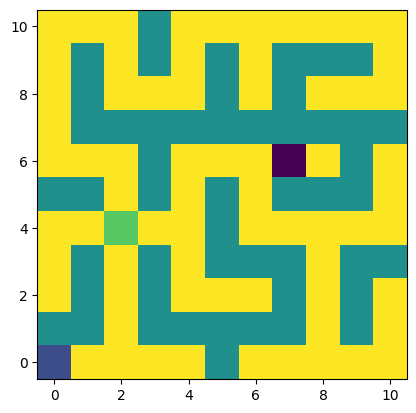

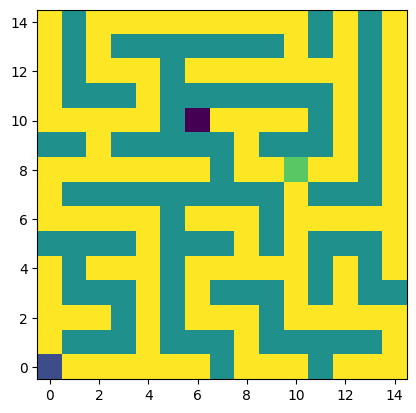

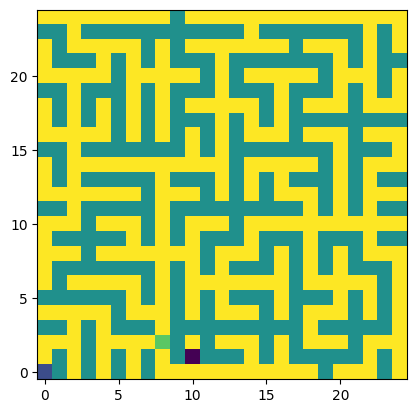

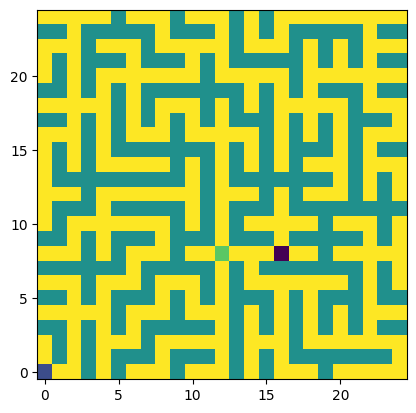

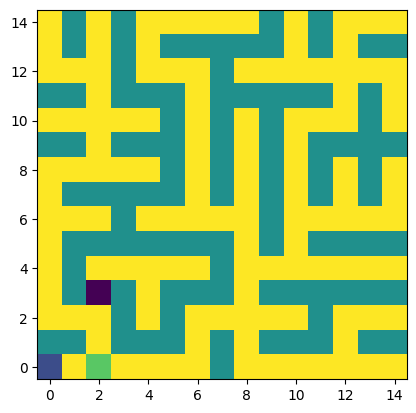

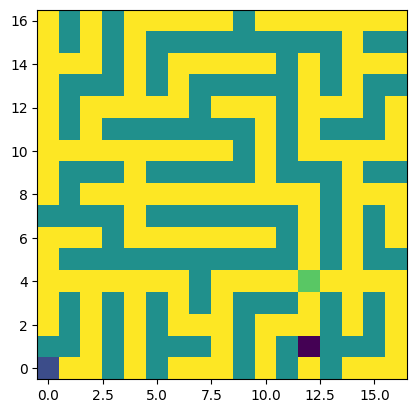

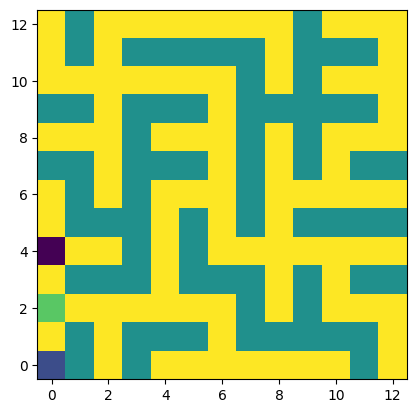

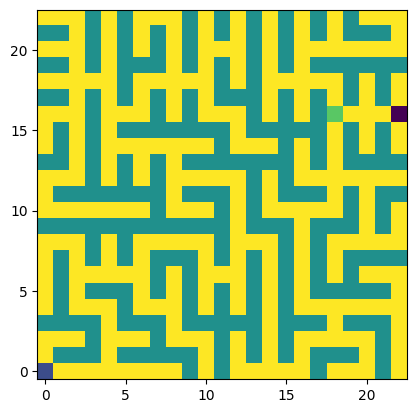

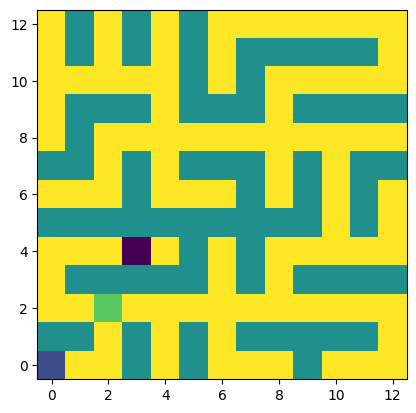

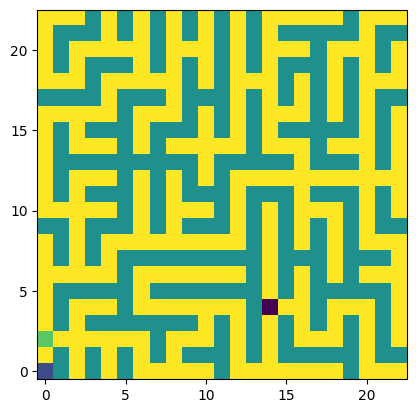

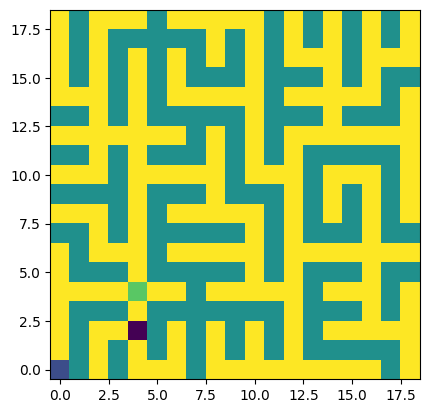

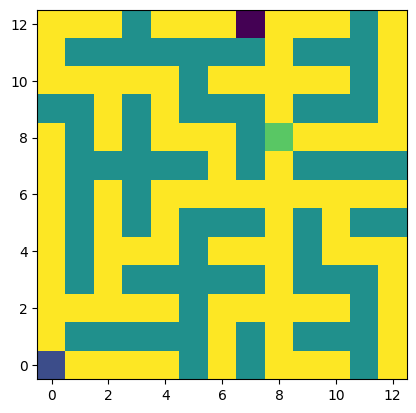

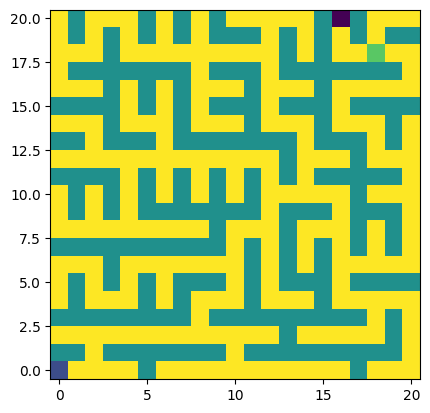

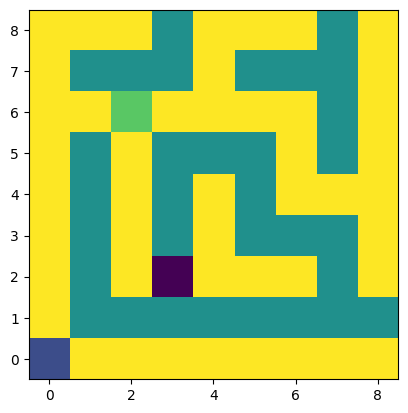

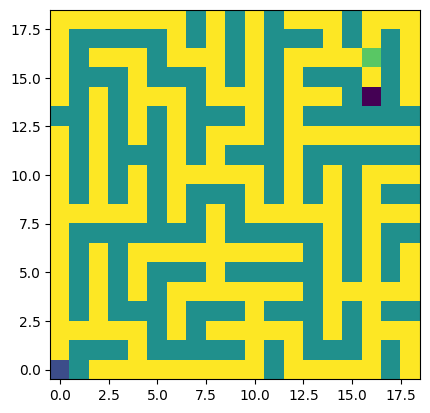

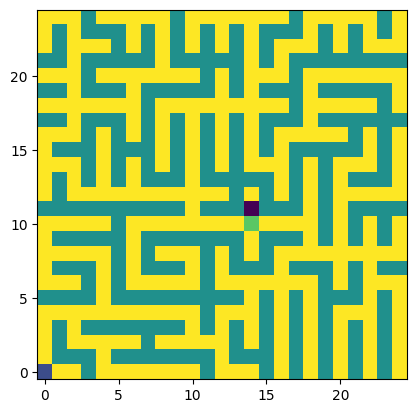

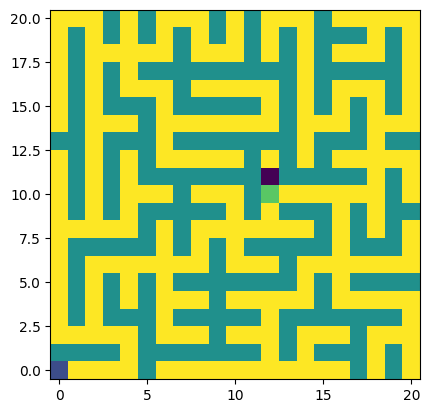

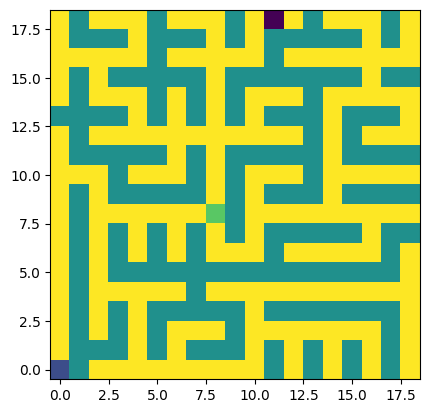

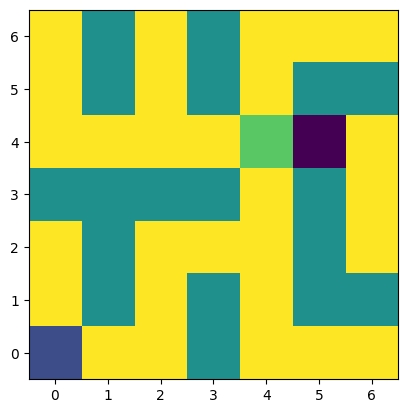

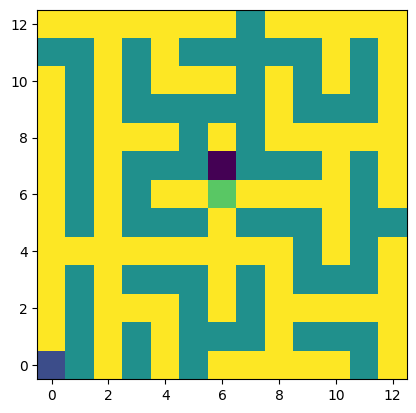

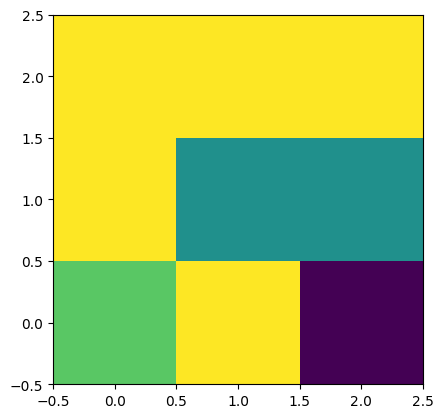

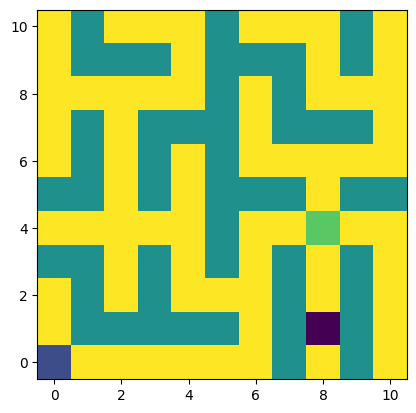

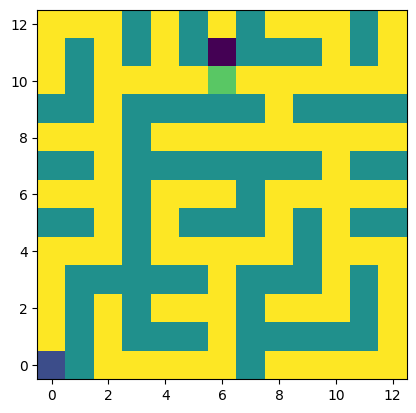

In [4]:
# num is the number of environments to create in the vec env
# num_levels is the number of levels to sample from (0 for infinite, 1 for deterministic)
venv = ProcgenGym3Env(
    num=200, env_name='maze', num_levels=0, start_level=0,
    distribution_mode='hard', num_threads=1, render_mode="rgb_array",
)
venv = maze.wrap_venv(venv)
infos = venv.env.get_info()
state_bytes_list = venv.env.callmethod("get_state")
state_vals_list = [maze.parse_maze_state_bytes(sb) for sb in state_bytes_list]
grids = [maze.inner_grid(maze.get_grid_with_mouse(sv)) for sv in state_vals_list]
obs = venv.reset()

# plot all the envs in the vectorized env
for i in range(obs.shape[0]):
    d_sq = decision_square(grids[i])
    if d_sq is not None:
        grids[i][d_sq] = 75

        #plt.imshow(obs[i].transpose(1, 2, 0))
        #plt.imshow(infos[i]['rgb'])
        plt.imshow(grids[i], origin='lower')
        plt.show()

In [5]:
pct = sum(1 for g in grids if decision_square(g) is not None) / len(grids)
print(f'{pct * 100:.2f}% of the mazes have a decision square')

61.00% of the mazes have a decision square
